In [19]:
import xarray as xr
import zarr
import glob
import datetime as dt
import pandas as pd
import numpy as np

In [2]:
def create_nice_dimensions(ds):
    # stack the time and sample dimensions so that the data is 1D
    ds_stacked = ds.stack(
        dimensions = {'time_sample': ['time', 'sample']}
    )

    # define a vectorized function to convert sample values (integers) to np.timedelta64[ns]
    convert_sample_to_timedelta = np.vectorize(
        lambda sample: np.timedelta64(int(sample * (1/20)*1e9))
    )
    # run it
    samples_timedeltas = convert_sample_to_timedelta(ds_stacked.sample)

    # define a vectorized function to convert time values (np.datetime64[ns] objects) to np.timedelta64[ns]
    # note that the time values have the correct minute and second
    convert_time_to_timedelta = np.vectorize(
        lambda time: np.timedelta64(int(
            pd.Timestamp(time).minute*60*1e9 + 
            pd.Timestamp(time).second*1e9 + 
            pd.Timestamp(time).microsecond*1000
        ))
    )
    # run it
    minutes_seconds = convert_time_to_timedelta(ds_stacked.time)
    
    # combine the 3 pieces of time information
    # base_time - has correct year, month, day, and hour
    # minutes_seconds - created from the `time` coordinate, has the correct minutes and seconds
    # samples_timedeltas - created from the `sample` coordinate, has the correct nanosecond
    # subtract half a second because the second provided by the `time` coordinate is marked on the half second
    complete_timestamps = ds_stacked.base_time.values + minutes_seconds + samples_timedeltas - int(0.5*1e9)

    ds_complete = ds_stacked.assign_coords({
        'time_complete': ('time_sample', complete_timestamps)
        }
    ).swap_dims(
        {'time_sample': 'time_complete'}
    ).reset_coords(drop=True).rename(
        {"time_complete": "time"}
    )
    
    return ds_complete

In [8]:
files = glob.glob("/data2/elilouis/sublimationofsnow/hr_noqc_geo/*.nc")
ds = xr.open_mfdataset(files, preprocess=create_nice_dimensions)

# Reynolds Averaging

## Exploratory

In [67]:
ex_ds = ds[['w_3m_c','h2o_3m_c']].copy()
averaging_period_samples = 20*60 # 1 minute for 20hz data

avg_ex_ds = ex_ds['w_3m_c'].coarsen(time=averaging_period_samples).mean()
avg_ex_ds = avg_ex_ds.assign_coords(time = avg_ex_ds.time.dt.round('1s'))
avg_ex_ds = avg_ex_ds.reindex_like(ds, method='nearest')

np.nanmax(
    np.abs(ex_ds['w_3m_c'].coarsen(time=averaging_period_samples).mean().values - avg_ex_ds.reindex_like(ds, method='nearest').coarsen(time=averaging_period_samples).mean().values)
)

1.1920929e-07

## Existing

In [72]:
def create_re_avg_ds(ds, re_avg_period_seconds):
    coarse_ds = ds.coarsen(time=re_avg_period_seconds).mean()
    coarse_ds = coarse_ds.assign_coords(time = coarse_ds.time.dt.round('1s'))
    coarse_ds = coarse_ds.reindex_like(ds, method='nearest')
    ds['w_3m_c_mean'] = coarse_ds['w_3m_c']
    ds['w_3m_c_fluc'] = ds['w_3m_c'] - ds['w_3m_c_mean']
    ds['h2o_3m_c_mean'] = coarse_ds['h2o_3m_c']
    ds['h2o_3m_c_fluc'] = ds['h2o_3m_c'] - ds['h2o_3m_c_mean']
    ds['w_h2o__3m_c'] = ds['h2o_3m_c_fluc'] * ds['w_3m_c_fluc']
    ds = ds.coarsen(time = re_avg_period_seconds).mean()
    ds = ds.assign_coords(time = ds.time.dt.round('1s'))
    return ds

In [86]:
re_avg_ds_1min = create_re_avg_ds(ds[['w_3m_c','h2o_3m_c']].copy(), 20*60)
re_avg_ds_1min['w_h2o__3m_c_cumulative'] = (re_avg_ds_1min['w_h2o__3m_c']*20*60).cumsum()

re_avg_ds_5min = create_re_avg_ds(ds[['w_3m_c','h2o_3m_c']].copy(), 20*60*5)
re_avg_ds_5min['w_h2o__3m_c_cumulative'] = (re_avg_ds_1min['w_h2o__3m_c']*20*60*5).cumsum()

re_avg_ds_10min = create_re_avg_ds(ds[['w_3m_c','h2o_3m_c']].copy(), 20*60*10)
re_avg_ds_10min['w_h2o__3m_c_cumulative'] = (re_avg_ds_1min['w_h2o__3m_c']*20*60*10).cumsum()

re_avg_ds_30min = create_re_avg_ds(ds[['w_3m_c','h2o_3m_c']].copy(), 20*60*30)
re_avg_ds_30min['w_h2o__3m_c_cumulative'] = (re_avg_ds_1min['w_h2o__3m_c']*20*60*30).cumsum()

re_avg_ds_60min = create_re_avg_ds(ds[['w_3m_c','h2o_3m_c']].copy(), 20*60*60)
re_avg_ds_60min['w_h2o__3m_c_cumulative'] = (re_avg_ds_1min['w_h2o__3m_c']*20*60*60).cumsum()

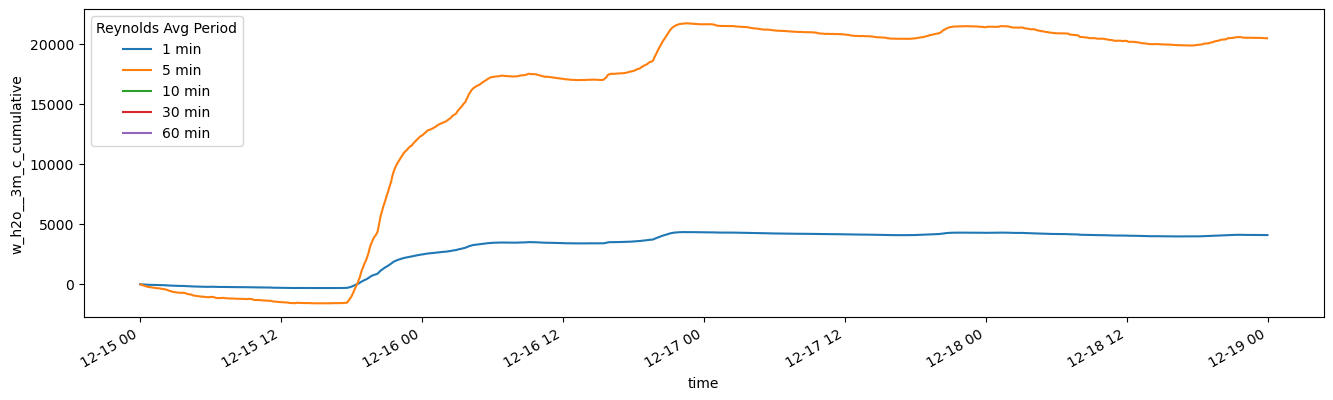

In [87]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,4))
re_avg_ds_1min['w_h2o__3m_c_cumulative'].plot(label = '1 min')
re_avg_ds_5min['w_h2o__3m_c_cumulative'].plot(label = '5 min')
re_avg_ds_10min['w_h2o__3m_c_cumulative'].plot(label = '10 min')
re_avg_ds_30min['w_h2o__3m_c_cumulative'].plot(label = '30 min')
re_avg_ds_60min['w_h2o__3m_c_cumulative'].plot(label = '60 min')
plt.legend(title='Reynolds Avg Period')

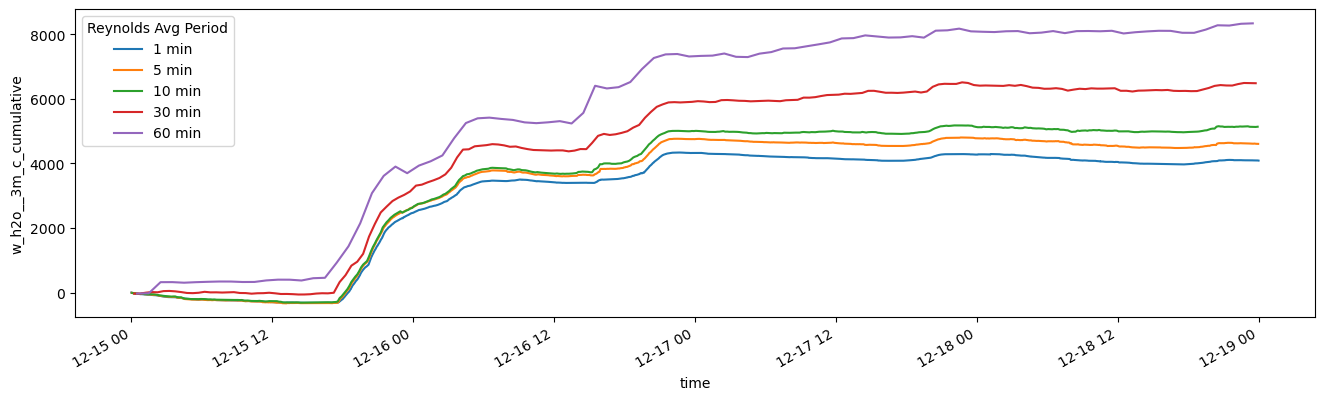

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,4))
re_avg_ds_1min['w_h2o__3m_c_cumulative'].plot(label="1 min")
re_avg_ds_5min['w_h2o__3m_c_cumulative'].plot(label="5 min")
re_avg_ds_10min['w_h2o__3m_c_cumulative'].plot(label="10 min")
re_avg_ds_30min['w_h2o__3m_c_cumulative'].plot(label="30 min")
re_avg_ds_60min['w_h2o__3m_c_cumulative'].plot(label="60 min")
plt.legend(title='Reynolds Avg Period')
# ax.set_yscale("log")

In [15]:
def create_re_avg_ds(ds, re_avg_period_seconds, fluc_1, fluc_2, cov_name):
    ds[f'{fluc_1}_mean'] = ds[f'{fluc_1}'].coarsen(time=re_avg_period_seconds).mean().reindex_like(ds, method='nearest')
    ds[f'{fluc_1}_fluc'] = ds[f'{fluc_1}'] - ds[f'{fluc_1}_mean']
    ds[f'{fluc_2}_mean'] = ds[f'{fluc_2}'].coarsen(time=re_avg_period_seconds).mean().reindex_like(ds, method='nearest')
    ds[f'{fluc_2}_fluc'] = ds[f'{fluc_2}'] - ds[f'{fluc_2}_mean']
    ds[cov_name] = ds[f'{fluc_2}_fluc'] * ds[f'{fluc_1}_fluc']
    ds = ds.coarsen(time = re_avg_period_seconds).mean()
    ds[f'{cov_name}_cumulative'] = ds[cov_name].cumsum()*re_avg_period_seconds
    return ds

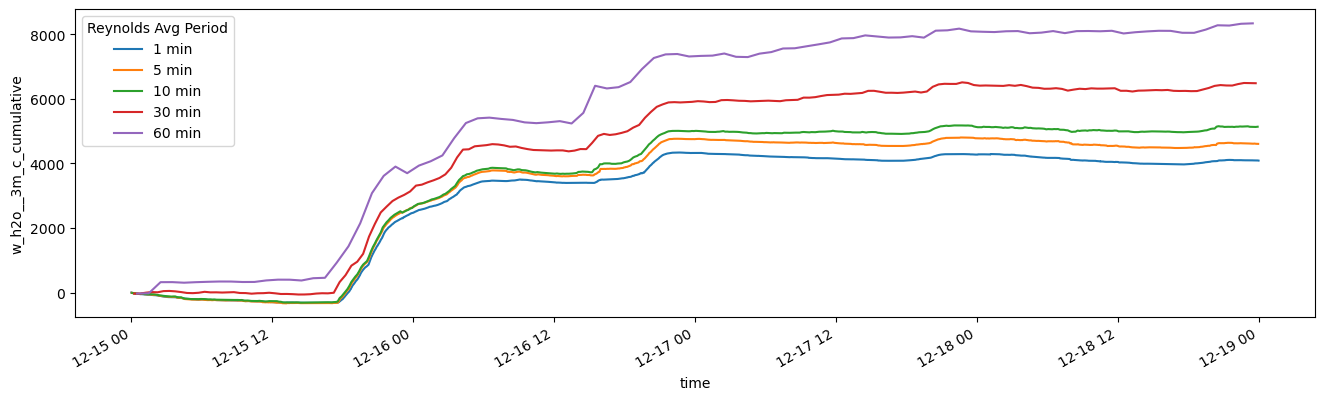

In [16]:
re_avg_ds_1min = create_re_avg_ds(ds[['w_3m_c','h2o_3m_c']].copy(), 20*60, 'w_3m_c', 'h2o_3m_c', 'w_h2o__3m_c')
re_avg_ds_5min = create_re_avg_ds(ds[['w_3m_c','h2o_3m_c']].copy(), 20*60*5, 'w_3m_c', 'h2o_3m_c', 'w_h2o__3m_c')
re_avg_ds_10min = create_re_avg_ds(ds[['w_3m_c','h2o_3m_c']].copy(), 20*60*10, 'w_3m_c', 'h2o_3m_c', 'w_h2o__3m_c')
re_avg_ds_30min = create_re_avg_ds(ds[['w_3m_c','h2o_3m_c']].copy(), 20*60*30, 'w_3m_c', 'h2o_3m_c', 'w_h2o__3m_c')
re_avg_ds_60min = create_re_avg_ds(ds[['w_3m_c','h2o_3m_c']].copy(), 20*60*60, 'w_3m_c', 'h2o_3m_c', 'w_h2o__3m_c')

fig, ax = plt.subplots(figsize=(16,4))
re_avg_ds_1min['w_h2o__3m_c_cumulative'].plot(label="1 min")
re_avg_ds_5min['w_h2o__3m_c_cumulative'].plot(label="5 min")
re_avg_ds_10min['w_h2o__3m_c_cumulative'].plot(label="10 min")
re_avg_ds_30min['w_h2o__3m_c_cumulative'].plot(label="30 min")
re_avg_ds_60min['w_h2o__3m_c_cumulative'].plot(label="60 min")
plt.legend(title='Reynolds Avg Period')

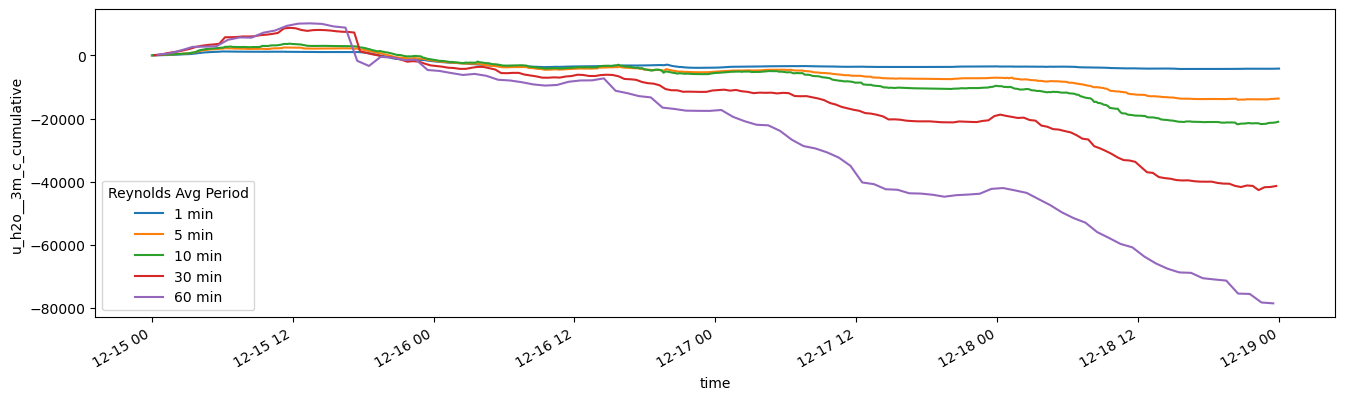

In [17]:
re_avg_ds_1min = create_re_avg_ds(ds[['u_3m_c','h2o_3m_c']].copy(), 20*60, 'u_3m_c', 'h2o_3m_c', 'u_h2o__3m_c')
re_avg_ds_5min = create_re_avg_ds(ds[['u_3m_c','h2o_3m_c']].copy(), 20*60*5, 'u_3m_c', 'h2o_3m_c', 'u_h2o__3m_c')
re_avg_ds_10min = create_re_avg_ds(ds[['u_3m_c','h2o_3m_c']].copy(), 20*60*10, 'u_3m_c', 'h2o_3m_c', 'u_h2o__3m_c')
re_avg_ds_30min = create_re_avg_ds(ds[['u_3m_c','h2o_3m_c']].copy(), 20*60*30, 'u_3m_c', 'h2o_3m_c', 'u_h2o__3m_c')
re_avg_ds_60min = create_re_avg_ds(ds[['u_3m_c','h2o_3m_c']].copy(), 20*60*60, 'u_3m_c', 'h2o_3m_c', 'u_h2o__3m_c')

fig, ax = plt.subplots(figsize=(16,4))
re_avg_ds_1min['u_h2o__3m_c_cumulative'].plot(label="1 min")
re_avg_ds_5min['u_h2o__3m_c_cumulative'].plot(label="5 min")
re_avg_ds_10min['u_h2o__3m_c_cumulative'].plot(label="10 min")
re_avg_ds_30min['u_h2o__3m_c_cumulative'].plot(label="30 min")
re_avg_ds_60min['u_h2o__3m_c_cumulative'].plot(label="60 min")
plt.legend(title='Reynolds Avg Period')

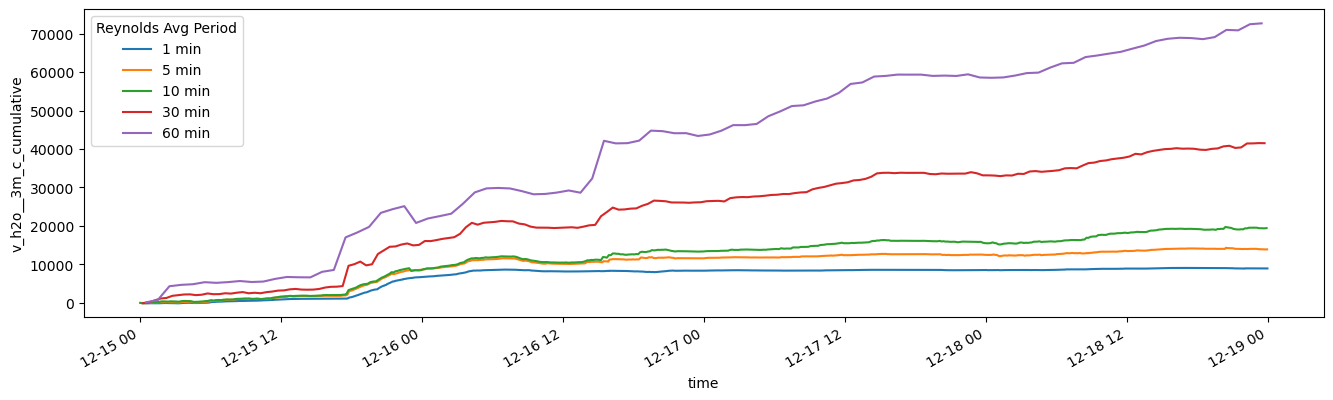

In [18]:
re_avg_ds_1min = create_re_avg_ds(ds[['v_3m_c','h2o_3m_c']].copy(), 20*60, 'v_3m_c', 'h2o_3m_c', 'v_h2o__3m_c')
re_avg_ds_5min = create_re_avg_ds(ds[['v_3m_c','h2o_3m_c']].copy(), 20*60*5, 'v_3m_c', 'h2o_3m_c', 'v_h2o__3m_c')
re_avg_ds_10min = create_re_avg_ds(ds[['v_3m_c','h2o_3m_c']].copy(), 20*60*10, 'v_3m_c', 'h2o_3m_c', 'v_h2o__3m_c')
re_avg_ds_30min = create_re_avg_ds(ds[['v_3m_c','h2o_3m_c']].copy(), 20*60*30, 'v_3m_c', 'h2o_3m_c', 'v_h2o__3m_c')
re_avg_ds_60min = create_re_avg_ds(ds[['v_3m_c','h2o_3m_c']].copy(), 20*60*60, 'v_3m_c', 'h2o_3m_c', 'v_h2o__3m_c')

fig, ax = plt.subplots(figsize=(16,4))
re_avg_ds_1min['v_h2o__3m_c_cumulative'].plot(label="1 min")
re_avg_ds_5min['v_h2o__3m_c_cumulative'].plot(label="5 min")
re_avg_ds_10min['v_h2o__3m_c_cumulative'].plot(label="10 min")
re_avg_ds_30min['v_h2o__3m_c_cumulative'].plot(label="30 min")
re_avg_ds_60min['v_h2o__3m_c_cumulative'].plot(label="60 min")
plt.legend(title='Reynolds Avg Period')